In [1]:
#импорт необходимых библиотек
import pandas as pd
import os as os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import numpy as np

import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report, precision_score, recall_score, f1_score,accuracy_score,roc_auc_score

In [2]:
file_path = os.path.join('../BKP_GIT/data/reviews_ready_binary.csv')# Загрузка данных из CSV файла
data = pd.read_csv(file_path)
data.head(5)# Демонстрация первых нескольких строк

,CabinType,EntertainmentRating,FoodRating,GroundServiceRating,OriginCountry,OverallScore,Recommended,Review,SeatComfortRating,ServiceRating,TravelType,ValueRating,WifiRating,Profile
0,Economy Class,0,4,4,Netherlands,9,1,Moroni to Moheli. Turned out to be a pretty de...,4,5,Solo Leisure,3,0,Promoter
1,Economy Class,0,1,1,UnitedKingdom,1,0,Moroni to Anjouan. It is a very small airline....,2,2,Solo Leisure,2,0,Detractor
2,Economy Class,0,1,1,UnitedKingdom,1,0,Anjouan to Dzaoudzi. A very small airline and ...,2,1,Solo Leisure,2,0,Detractor
3,Economy Class,0,0,0,Denmark,8,1,Havana - Cayo Coco return. A one hour flight w...,0,0,Family Leisure,4,0,Passive
4,Economy Class,0,0,0,UnitedKingdom,1,0,Holguin to Havana last week. Okay apart from i...,0,0,Solo Leisure,0,0,Detractor


In [3]:
def define_profile(rating):
    if 1 <= rating <= 2:
        return 'Критик'
    elif 3 <= rating <= 4:
        return 'Недоволен'
    elif 5 <= rating <= 6:
        return 'Нейтрален'
    elif 7 <= rating <= 8:
        return 'Доволен'
    elif 9 <= rating <= 10:
        return 'Промоутер'
    else:
        return None

data['Profile'] = data['OverallScore'].apply(define_profile)

In [4]:
profile_percentage = data.groupby(['CabinType', 'Profile']).size() / data.groupby('CabinType').size() * 100
profile_percentage = profile_percentage.unstack().fillna(0)

In [5]:
colors = {'Критик': 'red', 'Недоволен': 'orange', 'Нейтрален': 'yellow', 'Доволен':'lime', 'Промоутер':'green'}

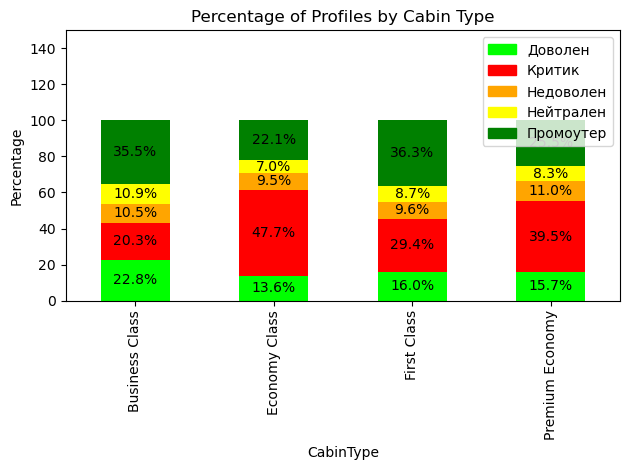

In [6]:
ax = profile_percentage.plot(kind='bar', stacked=True, color=[colors[col] for col in profile_percentage.columns])

plt.xlabel('CabinType')
plt.ylabel('Percentage')
plt.title('Percentage of Profiles by Cabin Type')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels], labels=labels)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=10, color='black')

plt.ylim(0, 150)
plt.tight_layout()
plt.show()

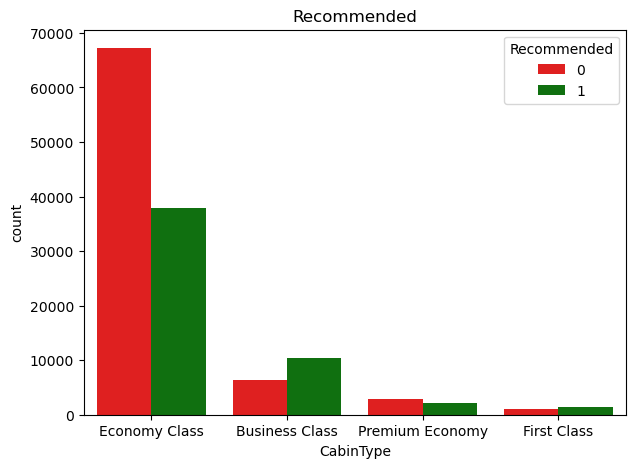

In [7]:
data.groupby(["Recommended","CabinType"])["Recommended"].count()
fig, axs = plt.subplots(figsize=(7, 5))
axs = sns.countplot(x='CabinType',hue='Recommended',data=data,palette=["red","green"]).set_title('Recommended')

In [8]:
data['Profile'] = data['Profile'].map({'Доволен' : 0,
                                       'Критик' : 1,
                                       'Недоволен' : 2,
                                       'Нейтрален' : 3,
                                       'Промоутер' : 4})

In [9]:
data.to_csv('../BKP_GIT/data/airlines_ready_multi.csv', index=False)

In [10]:
x = data[['EntertainmentRating',
          'FoodRating',
          'GroundServiceRating', 
          'SeatComfortRating',
          'ServiceRating', 
          'ValueRating',
          'WifiRating']]  # Признаки
y = data['Profile']       # Целевая переменная

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.30, random_state=42)

              precision    recall  f1-score   support

           0       0.50      0.57      0.53     12007
           1       0.90      0.83      0.86     42711
           2       0.25      0.35      0.29      6223
           3       0.29      0.37      0.33      5407
           4       0.78      0.71      0.75     24271

    accuracy                           0.70     90619
   macro avg       0.55      0.57      0.55     90619
weighted avg       0.74      0.70      0.72     90619



Text(0.5, 1.0, 'Accuracy Score 0.7')

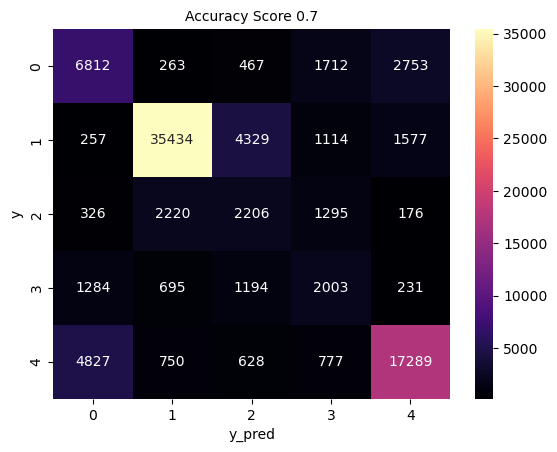

In [12]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(x_train,y_train)

y_pred = rf_model.predict(x_test)
accuracy_score(y_pred,y_test)

cm = confusion_matrix(y_pred,y_test)
acc = round(accuracy_score(y_pred,y_test),2)

print(classification_report(y_pred,y_test))

sns.heatmap(cm,annot=True, fmt=".0f",cmap = 'magma')
plt.xlabel("y_pred")
plt.ylabel("y")
plt.title(f"Accuracy Score {acc}",size=10)

              precision    recall  f1-score   support

           0       0.55      0.60      0.57     12485
           1       0.92      0.83      0.87     43710
           2       0.23      0.40      0.29      5164
           3       0.33      0.43      0.38      5400
           4       0.79      0.73      0.76     23860

    accuracy                           0.72     90619
   macro avg       0.57      0.60      0.58     90619
weighted avg       0.76      0.72      0.74     90619



Text(0.5, 1.0, 'Accuracy Score 0.72')

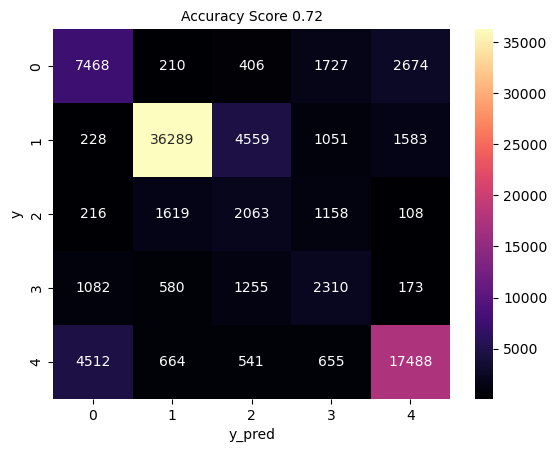

In [13]:
# XGBoost
xgboost_model = XGBClassifier()
xgboost_model.fit(x_train,y_train)

y_pred = xgboost_model.predict(x_test)
accuracy_score(y_pred,y_test)

cm = confusion_matrix(y_pred,y_test)
acc = round(accuracy_score(y_pred,y_test),2)

print(classification_report(y_pred,y_test))

sns.heatmap(cm,annot=True, fmt=".0f",cmap = 'magma')
plt.xlabel("y_pred")
plt.ylabel("y")
plt.title(f"Accuracy Score {acc}",size=10)

              precision    recall  f1-score   support

           0       0.58      0.60      0.59     13036
           1       0.93      0.83      0.87     44010
           2       0.23      0.41      0.29      4861
           3       0.33      0.44      0.38      5234
           4       0.79      0.74      0.76     23478

    accuracy                           0.73     90619
   macro avg       0.57      0.60      0.58     90619
weighted avg       0.77      0.73      0.74     90619



Text(0.5, 1.0, 'Accuracy Score 0.73')

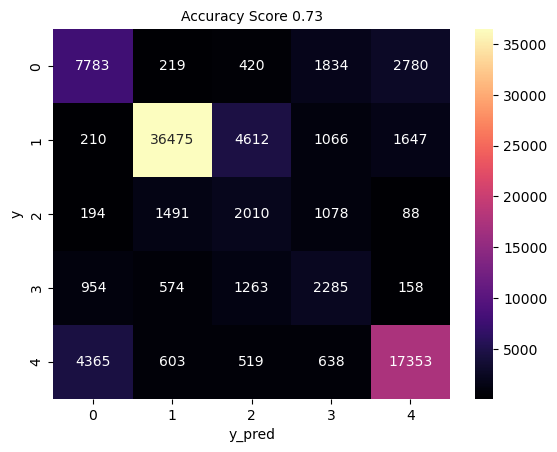

In [14]:
# LightGBM

lgb_model = lgb.LGBMClassifier(verbose=-1)
lgb_model.fit(x_train,y_train)

y_pred = lgb_model.predict(x_test)
accuracy_score(y_pred,y_test) # 0.963

cm = confusion_matrix(y_pred,y_test)
acc = round(accuracy_score(y_pred,y_test),2)

print(classification_report(y_pred,y_test))


sns.heatmap(cm,annot=True, fmt=".0f",cmap = 'magma')
plt.xlabel("y_pred")
plt.ylabel("y")
plt.title(f"Accuracy Score {acc}",size=10)

In [17]:
# RandomForestClassifier

rf_model = RandomForestClassifier()
rf_params = {"max_depth":[5,8],
             "max_features":[4,8,"auto"],
             "min_samples_split":[2,5,8],
             "n_estimators":[100,200,500]}

rf_best_grid = GridSearchCV(rf_model,rf_params,cv=5,n_jobs=-1,verbose=True).fit(x_train,y_train)
rf_best_grid.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\ProgramData\anaconda3\Lib\site-packages

{'max_depth': 8,
 'max_features': 8,
 'min_samples_split': 8,
 'n_estimators': 200}

In [19]:
rf_final = RandomForestClassifier().set_params(**rf_best_grid.best_params_).fit(x_train,y_train)
y_pred = rf_final.predict(x_test)

print(f"Accuracy:  {(accuracy_score(y_pred, y_test)):.2f}\nPrecision: \
{(precision_score(y_pred, y_test, average='weighted')):.2f}\nRecall:    \
{(recall_score(y_pred, y_test, average='weighted')):.2f}\nF1 score:  \
{(f1_score(y_pred, y_test, average='weighted')):.2f}\nROC:       \
{(roc_auc_score(y_pred, rf_final.predict_proba(x_test), multi_class='ovr', average='macro')):.2f}")

Accuracy:  0.72
Precision: 0.77
Recall:    0.72
F1 score:  0.74
ROC:       1.00


In [23]:
# XGBoost
xgboost_model = XGBClassifier()
xgboost_params = {"max_depth":[5,6],
             "learning_rate":[0.1,0.01],
             "colsample_bytree":[0.7,1],
             "n_estimators":[100,200,500]}

xgboost_best_grid = GridSearchCV(xgboost_model,xgboost_params,cv=5,n_jobs=-1,verbose=True).fit(x_train,y_train)
xgboost_best_grid.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100}

In [26]:
xgboost_final = XGBClassifier().set_params(**xgboost_best_grid.best_params_).fit(x_train,y_train)
y_pred = xgboost_final.predict(x_test)

print(f"Accuracy:  {(accuracy_score(y_pred, y_test)):.2f}\nPrecision: \
{(precision_score(y_pred, y_test, average='weighted')):.2f}\nRecall:    \
{(recall_score(y_pred, y_test, average='weighted')):.2f}\nF1 score:  \
{(f1_score(y_pred, y_test, average='weighted')):.2f}\nROC:       \
{(roc_auc_score(y_pred, rf_final.predict_proba(x_test), multi_class='ovr', average='macro')):.2f}")

Accuracy:  0.73
Precision: 0.78
Recall:    0.73
F1 score:  0.75
ROC:       0.99


In [28]:
# LightGBM
lgb_model = lgb.LGBMClassifier(verbose=-1)
lgbm_params = {"learning_rate":[0.1,0.01],
             "colsample_bytree":[0.7,1],
             "n_estimators":[100,200,500]
               }

lgbm_best_grid = GridSearchCV(lgb_model,lgbm_params,cv=5,n_jobs=-1,verbose=0).fit(x_train,y_train)
lgbm_best_grid.best_params_

{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 500}

In [30]:
lgbm_final = lgb.LGBMClassifier(verbose=-1).set_params(**lgbm_best_grid.best_params_).fit(x,y)
y_pred = lgbm_final.predict(x_test)

print(f"Accuracy:  {(accuracy_score(y_pred, y_test)):.2f}\nPrecision: \
{(precision_score(y_pred, y_test, average='weighted')):.2f}\nRecall:    \
{(recall_score(y_pred, y_test, average='weighted')):.2f}\nF1 score:  \
{(f1_score(y_pred, y_test, average='weighted')):.2f}\nROC:       \
{(roc_auc_score(y_pred, rf_final.predict_proba(x_test), multi_class='ovr', average='macro')):.2f}")

Accuracy:  0.74
Precision: 0.78
Recall:    0.74
F1 score:  0.75
ROC:       0.99


In [32]:
rf_feature_imp = pd.DataFrame({"Value":rf_final.feature_importances_, "Feature":x_train.columns})
xgb_feature_imp = pd.DataFrame({"Value":xgboost_final.feature_importances_, "Feature":x_train.columns})
lgb_feature_imp = pd.DataFrame({"Value":lgbm_final.feature_importances_, "Feature":x_train.columns})

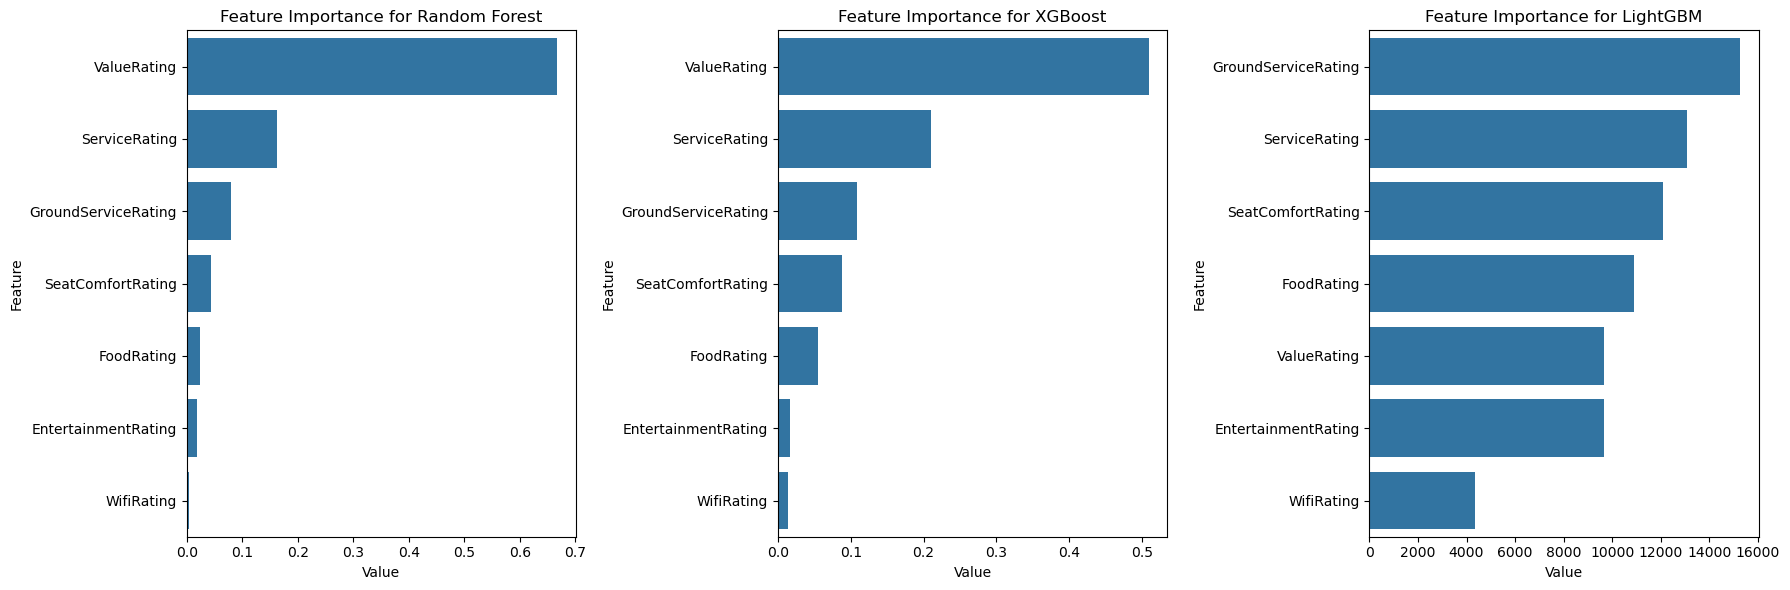

In [34]:
fig, axs = plt.subplots(1,3,figsize=(18,6))

sns.barplot(x="Value",y="Feature",data=rf_feature_imp.sort_values(by="Value",ascending=False)[0:len(x_train)],ax=axs[0])
axs[0].set_title('Feature Importance for Random Forest')
sns.barplot(x="Value",y="Feature",data=xgb_feature_imp.sort_values(by="Value",ascending=False)[0:len(x_train)],ax=axs[1])
axs[1].set_title('Feature Importance for XGBoost')
sns.barplot(x="Value",y="Feature",data=lgb_feature_imp.sort_values(by="Value",ascending=False)[0:len(x_train)],ax=axs[2])
axs[2].set_title('Feature Importance for LightGBM')
plt.tight_layout()

In [36]:
classifiers = [("RandomForestClassifier",RandomForestClassifier(),RandomForestClassifier(max_depth= 8,max_features=8,min_samples_split= 5,n_estimators=100)),
               ("XGBClassifier",XGBClassifier(),XGBClassifier(colsample_bytree= 0.7,learning_rate=0.1,max_depth= 5,n_estimators=100)),
               ("LGBMClassifier",lgb.LGBMClassifier(verbose=-1),lgb.LGBMClassifier(colsample_bytree= 0.7,learning_rate=0.1,n_estimators=100,verbose=-1))]

In [38]:
def calculate(y):
    acc = accuracy_score(y,y_test)
    pre = precision_score(y,y_test)
    rec = recall_score(y,y_test)
    f1 = f1_score(y,y_test)
    auc = roc_auc_score(y,y_test)
    return acc,pre,rec,f1,auc

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def calculate_metrics(y_true, y_pred, model, x_test):
    """Вычисляет метрики с учетом типа классификации"""
    n_classes = len(np.unique(y_true))
    
    accuracy = accuracy_score(y_true, y_pred)
    
    avg_method = 'binary' if n_classes == 2 else 'weighted'
    
    precision = precision_score(y_true, y_pred, average=avg_method)
    recall = recall_score(y_true, y_pred, average=avg_method)
    f1 = f1_score(y_true, y_pred, average=avg_method)
    
    try:
        proba = model.predict_proba(x_test)
        if n_classes == 2:
            roc_auc = roc_auc_score(y_true, proba[:, 1])
        else:
            roc_auc = roc_auc_score(y_true, proba, multi_class='ovr', average='macro')
    except (AttributeError, IndexError, ValueError):
        roc_auc = np.nan
    
    return accuracy, precision, recall, f1, roc_auc

def model_call(x_train, x_test, y_train, y_test, mod_opt=False, plot=False):
    """Оценивает модели с автоматическим определением типа классификации"""
    results_before = []
    results_after = []
    
    for i, (name, model, optimized_model) in enumerate(classifiers):
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        metrics_before = calculate_metrics(y_test, y_pred, model, x_test)
        results_before.append(metrics_before)
        
        if mod_opt:
            optimized_model.fit(x_train, y_train)
            y_pred_opt = optimized_model.predict(x_test)
            metrics_after = calculate_metrics(y_test, y_pred_opt, optimized_model, x_test)
            results_after.append(metrics_after)
        
        print(f"{name.upper()}")
        print("Before:")
        print(f"Accuracy: {metrics_before[0]:.3f} | Precision: {metrics_before[1]:.3f} | "
              f"Recall: {metrics_before[2]:.3f} | F1: {metrics_before[3]:.3f} | "
              f"ROC-AUC: {metrics_before[4]:.3f}")
        
        if mod_opt:
            print("After optimization:")
            print(f"Accuracy: {metrics_after[0]:.3f} | Precision: {metrics_after[1]:.3f} | "
                  f"Recall: {metrics_after[2]:.3f} | F1: {metrics_after[3]:.3f} | "
                  f"ROC-AUC: {metrics_after[4]:.3f}")
        print("-" * 80)
    
    if plot:
        for model in [model, optimized_model] if mod_opt else [model]:
            try:
                plot_importance(model, x_train)
            except Exception as e:
                print(f"Could not plot feature importance: {str(e)}")

model_call(x_train, x_test, y_train, y_test, mod_opt=True, plot=False)

RANDOMFORESTCLASSIFIER
Before:
Accuracy: 0.702 | Precision: 0.679 | Recall: 0.702 | F1: 0.688 | ROC-AUC: 0.883
After optimization:
Accuracy: 0.723 | Precision: 0.696 | Recall: 0.723 | F1: 0.704 | ROC-AUC: 0.911
--------------------------------------------------------------------------------
XGBCLASSIFIER
Before:
Accuracy: 0.724 | Precision: 0.699 | Recall: 0.724 | F1: 0.708 | ROC-AUC: 0.912
After optimization:
Accuracy: 0.730 | Precision: 0.704 | Recall: 0.730 | F1: 0.711 | ROC-AUC: 0.917
--------------------------------------------------------------------------------
LGBMCLASSIFIER
Before:
Accuracy: 0.727 | Precision: 0.702 | Recall: 0.727 | F1: 0.710 | ROC-AUC: 0.915
After optimization:
Accuracy: 0.729 | Precision: 0.705 | Recall: 0.729 | F1: 0.712 | ROC-AUC: 0.916
--------------------------------------------------------------------------------


In [ ]:
В результате исследования моделей для решения задачи многоклассовой классификации было выявлено, 
что на данном наборе обучаюх данных, модели показывают метрики хуже, чем на бинарной.
В следующем блокноте рассмотрим последовательное обучение моделей. 
Сначала обучим для бинарной классификации, после для многоклассовой.
Продолжение в блокноте 